<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
Daily Aggrgeation of NOAA VIIRS I-Bands AF Fire Pixels
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

The Jupyter notebook demonstrates a simple workflow that can be used to spatially aggregate the NOAA VIIRS I-Band Active Fire product for any given day.

In [48]:
from calendar import monthrange
from matplotlib.pyplot import figure
from pylab import matplotlib

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.cm as cm
import warnings


warnings.filterwarnings('ignore')

In [49]:
root = '/Volumes/HD2/Datasets/Research'

In [50]:
year = 2023
month = 2
day = 20

timestamp = '_{:02d}_{:02d}_{:02d}'.format(year,month,day)

timestamp

'_2023_02_20'

## List of all files for a given day

In [51]:
platform = 'SNPP'
platform = 'NOAA20'

product = 'SNPP_VIIRS_AF_I-Band_EDR_NRT'
product = 'AF_Iband_VIIRS_EDR'

AF_IBAND_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/{}/{:04d}/{:04d}_{:02d}_{:02d}/*.nc'.format(root,platform,product,year,year,month,day))

print( len(AF_IBAND_Files) )

1013


## Store Fire Pixels in a Pandas DataFrame 

In [52]:
%%time

df = pd.DataFrame()

for idx,AF_IBAND_File in enumerate(AF_IBAND_Files):
                    
    df_new = pd.DataFrame()

    #print(granule_year,granule_month,granule_day)

    f = netCDF4.Dataset(AF_IBAND_File)

    fpg = f.groups['Fire Pixels']

    for name in ['FP_latitude', 
                 'FP_longitude', 
                 'FP_ViewZenAng',  
                 'FP_T4',
                 'FP_T5',
                 'FP_power', 'FP_PersistentAnomalyCategory']:

        data_obj = fpg.variables[name]

        data =  ma.getdata(data_obj)

        #df_new[name+timestamp] = data.ravel()  
        df_new[name] = data.ravel()  
    
    #df_new['Day_Night_Flag'+timestamp] = f.day_night_data_flag  
    df_new['Day_Night_Flag'] = f.day_night_data_flag  
    
    f.close()

    df = pd.concat([df,df_new], axis=0)  

CPU times: user 9.89 s, sys: 529 ms, total: 10.4 s
Wall time: 12.5 s


In [53]:
df

,FP_latitude,FP_longitude,FP_ViewZenAng,FP_T4,FP_T5,FP_power,FP_PersistentAnomalyCategory,Day_Night_Flag
0,52.810963,53.015335,63.598392,320.377594,254.419098,2.255534,1,Night
1,54.087730,38.185356,23.013353,320.350922,271.618103,2.562029,5,Night
2,52.547501,39.638100,32.743870,327.118347,261.849762,4.931502,5,Night
3,52.558895,39.569374,32.460766,326.681580,258.673218,8.714921,5,Night
4,52.557247,39.576691,32.492195,321.753418,266.756744,10.364797,5,Night
...,...,...,...,...,...,...,...,...
8,-4.520759,11.417427,57.239635,323.141357,284.229553,2.146481,1,Night
9,-4.520154,11.413948,57.252048,303.511139,284.103180,2.146481,1,Night
10,-5.200759,11.698128,55.696411,331.976166,282.351715,4.957764,1,Night
11,-5.200071,11.697698,55.670147,312.302277,281.337311,3.892190,1,Night


In [54]:
df.columns

Index(['FP_latitude', 'FP_longitude', 'FP_ViewZenAng', 'FP_T4', 'FP_T5',
       'FP_power', 'FP_PersistentAnomalyCategory', 'Day_Night_Flag'],
      dtype='object')

## Plot Fire Pixels on a Global Map

In [55]:
FP_PersistentAnomalyCategory_Legend = {0:'none',
1: 'oil or gas',
2: 'volcano',
3: 'solar panel',
4: 'urban',
5: 'unclassified'}

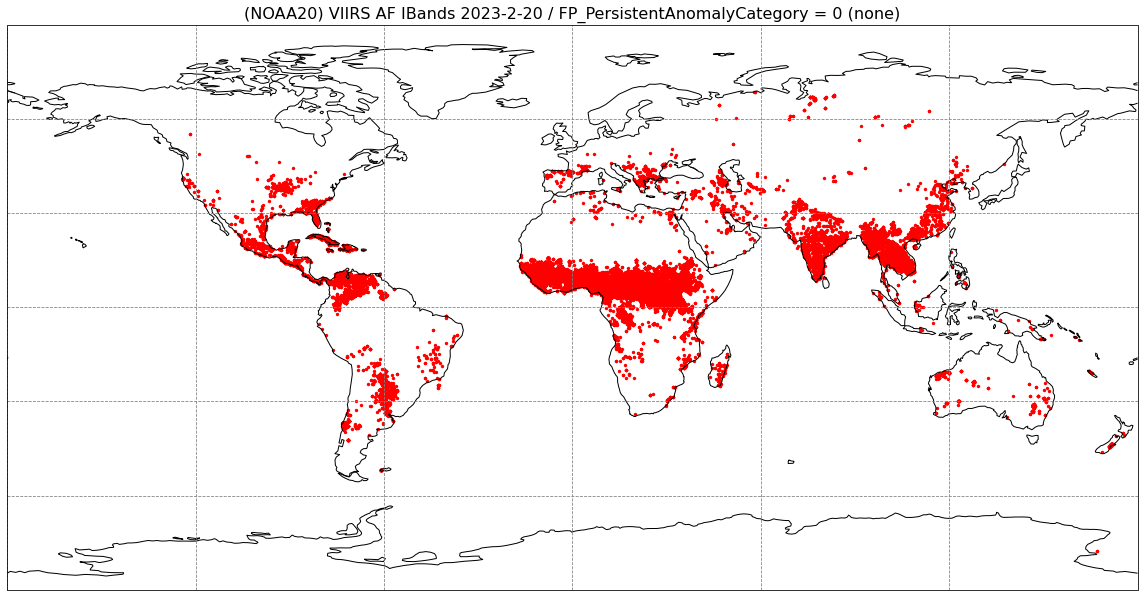

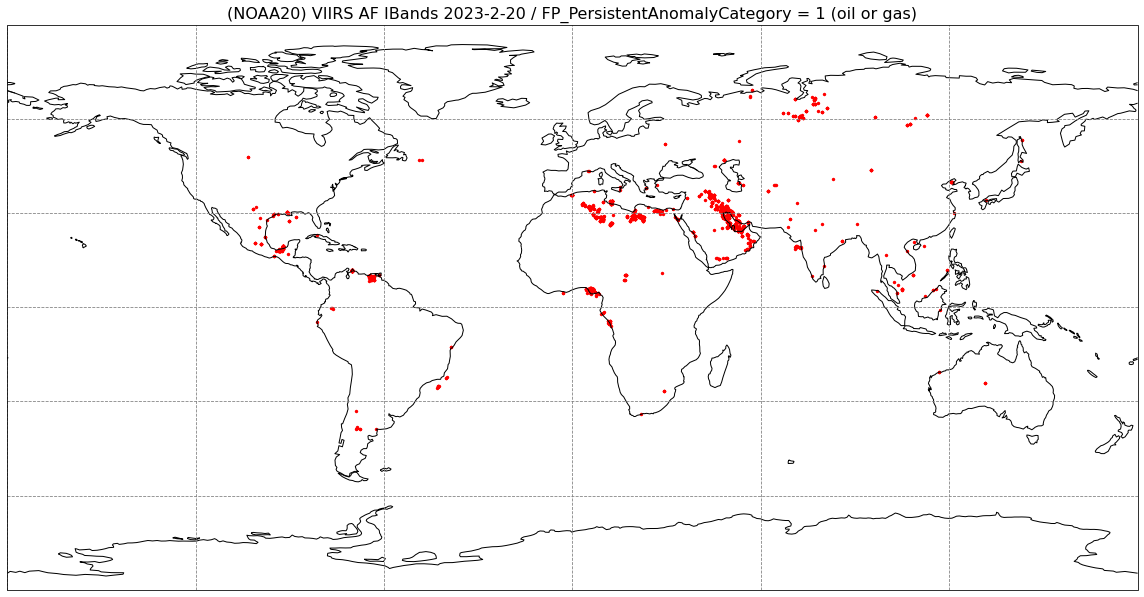

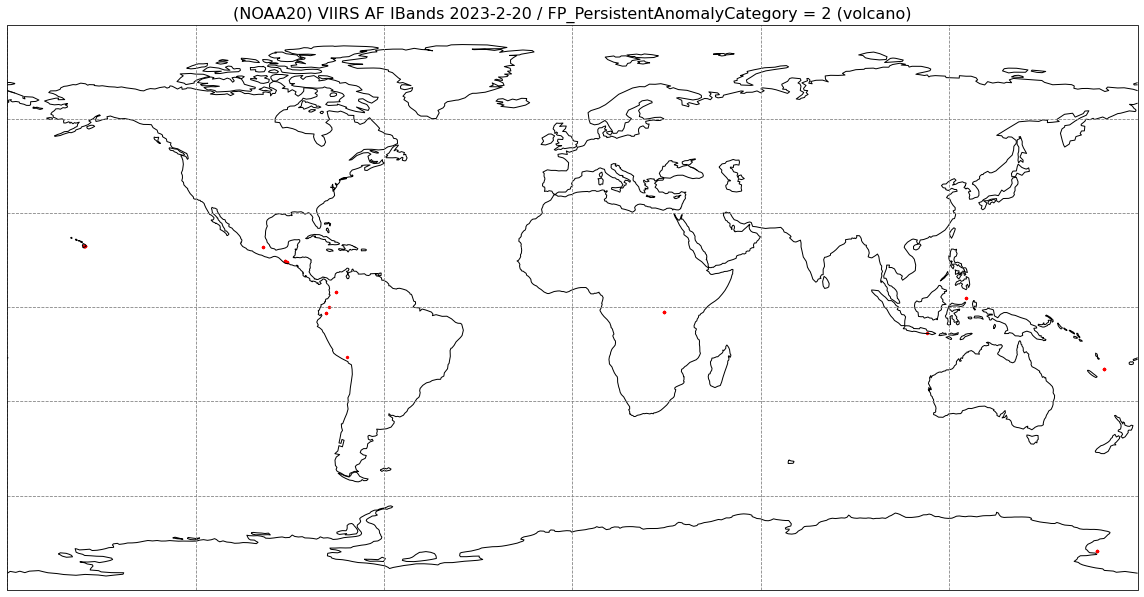

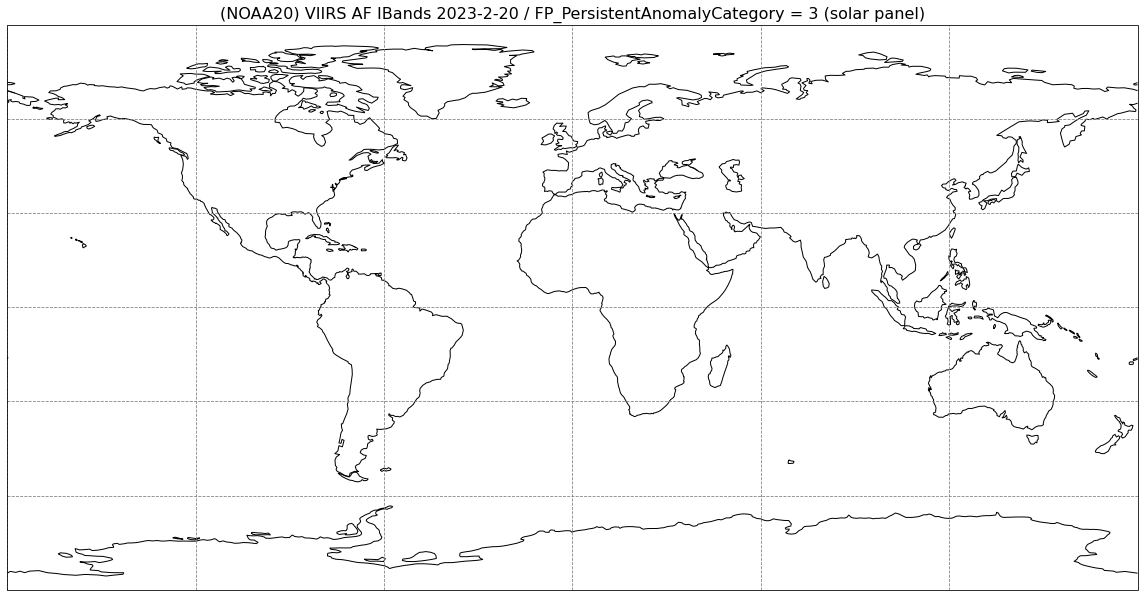

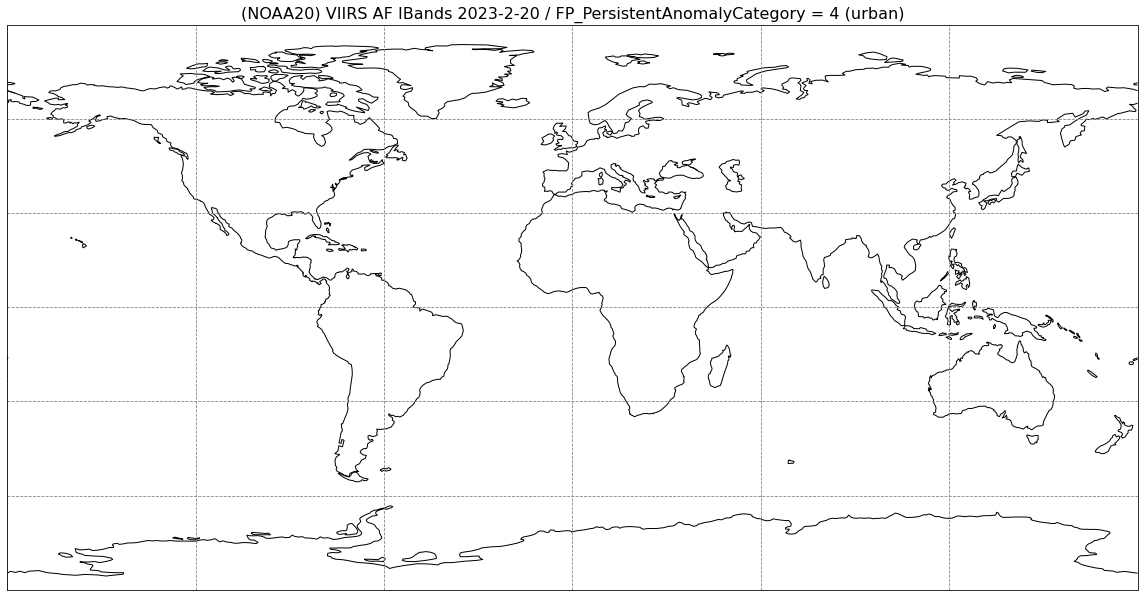

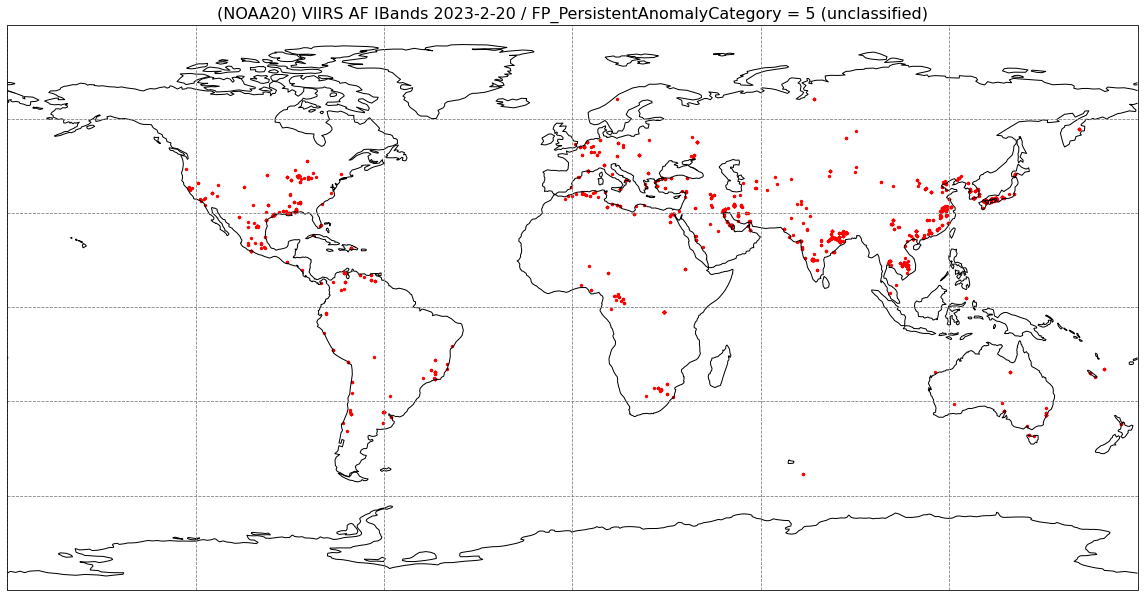

In [56]:
for PersistentAnomalyCategory in [0,1,2,3,4,5]:

    plt.figure(figsize=(16,9))

    proj = ccrs.PlateCarree()

    ease_extent = [-180., 180., 90., -90.]

    ax = plt.axes(projection=proj)

    ax.set_extent(ease_extent, crs=proj) 

    ax.gridlines(color='gray', linestyle='--')

    ax.coastlines()

    ny_lon, ny_lat = -75, 43
    delhi_lon, delhi_lat = 77.23, 28.61
    
    longs = df[ df['FP_PersistentAnomalyCategory'] == PersistentAnomalyCategory ]['FP_longitude']
    lats = df[ df['FP_PersistentAnomalyCategory'] == PersistentAnomalyCategory ]['FP_latitude']

    plt.scatter( longs, lats,
             color='red', linewidth=2, marker='o', s=2,
             transform=ccrs.PlateCarree(),
             )

    plt.title('({}) VIIRS AF IBands {}-{}-{} / FP_PersistentAnomalyCategory = {} ({})'.format(platform,year,month,day,PersistentAnomalyCategory,FP_PersistentAnomalyCategory_Legend[PersistentAnomalyCategory]),fontsize=16)
    
    plt.tight_layout()
    
    plt.savefig('./outputs/{}_AF_Iband_PAC_{}_2022_07_08.png'.format(platform,PersistentAnomalyCategory), dpi=150, facecolor='white')
    
    plt.show()
    
    plt.close

## Scatter Plot I-band 4 vs 5 

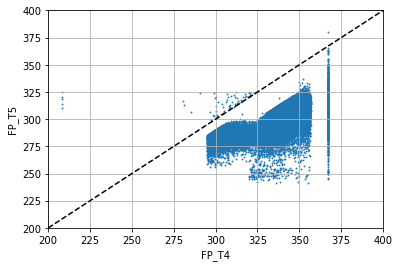

In [57]:
plt.scatter(df['FP_T4'],df['FP_T5'],s=0.7)

plt.plot([200,400],[200,400],'--',c='k')

plt.grid()

plt.xlim(200,400)
plt.ylim(200,400)

plt.xlabel('FP_T4')
plt.ylabel('FP_T5')

plt.savefig("./outputs/ibands_5_vs_4_fire_pixels.png", bbox_inches='tight',dpi=200, facecolor='white')

plt.show()

## Daily spatial aggregation

In [58]:
resolution = 0.05

In [59]:
def quantitative_to_categorical_converter(x,col1,col2,resolution):
    lat_idx = int( (x[col1]+90.0) / resolution )
    long_idx = int( (x[col2]+180) / resolution )
    return int( 360 / resolution ) * lat_idx + long_idx

In [60]:
%%time

df['Index'] = df.apply(quantitative_to_categorical_converter, 
                       axis=1, 
                       col1 = 'FP_latitude',
                       col2 = 'FP_longitude',
                       resolution=resolution)

df[ ['Index', 'FP_latitude', 'FP_longitude'] ]

CPU times: user 488 ms, sys: 6.04 ms, total: 494 ms
Wall time: 493 ms


,Index,FP_latitude,FP_longitude
0,20567860,52.810963,53.015335
1,20747563,54.087730,38.185356
2,20524392,52.547501,39.638100
3,20531591,52.558895,39.569374
4,20531591,52.557247,39.576691
...,...,...,...
8,12308628,-4.520759,11.417427
9,12308628,-4.520154,11.413948
10,12207833,-5.200759,11.698128
11,12207833,-5.200071,11.697698


Retrieve latitude

In [61]:
5737481 / ( 360 / 0.1 ) * 0.1 - 90

69.37447222222224

Retrieve longitude

In [62]:
5737481 - int (5737481 * 0.1 / 360 ) * 360 / 0.1

2681.0

In [63]:
2681.0 * 0.1 - 180

88.10000000000002

### GroupBy

In [64]:
dfg_2022_09_01 = df[['Index','FP_power']].groupby(['Index']).sum()

dfg_2022_09_01

,FP_power
Index,
1799743,51.708588
5311470,18.355694
5503177,75.621262
5503178,1137.488159
6314174,1.205367
...,...
22728402,3.123714
22835960,2.886505
22835961,2.566102


In [65]:
df[['Index','FP_PersistentAnomalyCategory']].groupby(['Index']).count()

,FP_PersistentAnomalyCategory
Index,
1799743,5
5311470,2
5503177,5
5503178,36
6314174,1
...,...
22728402,1
22835960,1
22835961,1


In [66]:
df[['Index','FP_PersistentAnomalyCategory']].groupby(["Index"])["FP_PersistentAnomalyCategory"].value_counts(normalize=True).mul(100).unstack("FP_PersistentAnomalyCategory").fillna(0)

FP_PersistentAnomalyCategory,0,1,2,5
Index,,,,
1799743,40.0,0.0,60.0,0.0
5311470,0.0,0.0,0.0,100.0
5503177,100.0,0.0,0.0,0.0
5503178,100.0,0.0,0.0,0.0
6314174,100.0,0.0,0.0,0.0
...,...,...,...,...
22728402,0.0,100.0,0.0,0.0
22835960,100.0,0.0,0.0,0.0
22835961,100.0,0.0,0.0,0.0


## Store data in a HDF5 file

In [67]:
store = pd.HDFStore('./outputs/AF_2022_09_01.hdf5')

store.put('dataset_01', df)

metadata = {}

store.get_storer('dataset_01').attrs.metadata = metadata

store.close()

Read the HDF5 file

In [68]:
with pd.HDFStore('./outputs/AF_2022_09_01.hdf5') as store:
    data = store['dataset_01']
    metadata = store.get_storer('dataset_01').attrs.metadata

print(data)

print(metadata)

    FP_latitude  FP_longitude  FP_ViewZenAng       FP_T4       FP_T5  \
0     52.810963     53.015335      63.598392  320.377594  254.419098   
1     54.087730     38.185356      23.013353  320.350922  271.618103   
2     52.547501     39.638100      32.743870  327.118347  261.849762   
3     52.558895     39.569374      32.460766  326.681580  258.673218   
4     52.557247     39.576691      32.492195  321.753418  266.756744   
..          ...           ...            ...         ...         ...   
8     -4.520759     11.417427      57.239635  323.141357  284.229553   
9     -4.520154     11.413948      57.252048  303.511139  284.103180   
10    -5.200759     11.698128      55.696411  331.976166  282.351715   
11    -5.200071     11.697698      55.670147  312.302277  281.337311   
12    -5.200642     11.700938      55.657978  310.676514  282.537720   

     FP_power  FP_PersistentAnomalyCategory Day_Night_Flag     Index  
0    2.255534                             1          Night  2056

## Create a global FRP map

In [69]:
data = np.zeros(( int(180 / resolution) , int(360 / resolution) ))

shape = data.shape

print(data.shape)
print(data.size)

(3600, 7200)
25920000


In [70]:
df_map = pd.DataFrame()

xv, yv = np.meshgrid(np.arange( -90,90, resolution), np.arange(-180,180,resolution))

df_map['latitude'] = xv.ravel()
df_map['longitude'] = yv.ravel()

df_map

,latitude,longitude
0,-90.00,-180.00
1,-89.95,-180.00
2,-89.90,-180.00
3,-89.85,-180.00
4,-89.80,-180.00
...,...,...
25919995,89.75,179.95
25919996,89.80,179.95
25919997,89.85,179.95
25919998,89.90,179.95


In [71]:
%%time

df_map['Index'] = df_map.apply(quantitative_to_categorical_converter, 
                       axis=1, 
                       col1 = 'latitude',
                       col2 = 'longitude',
                       resolution=resolution)

CPU times: user 3min 26s, sys: 2.4 s, total: 3min 29s
Wall time: 3min 29s


In [72]:
df_map

,latitude,longitude,Index
0,-90.00,-180.00,0
1,-89.95,-180.00,0
2,-89.90,-180.00,7200
3,-89.85,-180.00,14400
4,-89.80,-180.00,21600
...,...,...,...
25919995,89.75,179.95,25883999
25919996,89.80,179.95,25891199
25919997,89.85,179.95,25898399
25919998,89.90,179.95,25905599


In [73]:
df_map.dtypes

latitude     float64
longitude    float64
Index          int64
dtype: object

In [74]:
df

,FP_latitude,FP_longitude,FP_ViewZenAng,FP_T4,FP_T5,FP_power,FP_PersistentAnomalyCategory,Day_Night_Flag,Index
0,52.810963,53.015335,63.598392,320.377594,254.419098,2.255534,1,Night,20567860
1,54.087730,38.185356,23.013353,320.350922,271.618103,2.562029,5,Night,20747563
2,52.547501,39.638100,32.743870,327.118347,261.849762,4.931502,5,Night,20524392
3,52.558895,39.569374,32.460766,326.681580,258.673218,8.714921,5,Night,20531591
4,52.557247,39.576691,32.492195,321.753418,266.756744,10.364797,5,Night,20531591
...,...,...,...,...,...,...,...,...,...
8,-4.520759,11.417427,57.239635,323.141357,284.229553,2.146481,1,Night,12308628
9,-4.520154,11.413948,57.252048,303.511139,284.103180,2.146481,1,Night,12308628
10,-5.200759,11.698128,55.696411,331.976166,282.351715,4.957764,1,Night,12207833
11,-5.200071,11.697698,55.670147,312.302277,281.337311,3.892190,1,Night,12207833


In [75]:
df.dtypes

FP_latitude                     float32
FP_longitude                    float32
FP_ViewZenAng                   float32
FP_T4                           float32
FP_T5                           float32
FP_power                        float32
FP_PersistentAnomalyCategory      uint8
Day_Night_Flag                   object
Index                             int64
dtype: object

In [76]:
dfg_2022_09_01 = dfg_2022_09_01.reset_index()

dfg_2022_09_01

,Index,FP_power
0,1799743,51.708588
1,5311470,18.355694
2,5503177,75.621262
3,5503178,1137.488159
4,6314174,1.205367
...,...,...
28917,22728402,3.123714
28918,22835960,2.886505
28919,22835961,2.566102
28920,22843159,2.932632


In [77]:
dfg_2022_09_01.dtypes

Index         int64
FP_power    float32
dtype: object

In [78]:
dfg_2022_09_01

,Index,FP_power
0,1799743,51.708588
1,5311470,18.355694
2,5503177,75.621262
3,5503178,1137.488159
4,6314174,1.205367
...,...,...
28917,22728402,3.123714
28918,22835960,2.886505
28919,22835961,2.566102
28920,22843159,2.932632


In [79]:
df_merged = pd.merge(df,df_map, on=['Index'], how='inner')

df_merged

,FP_latitude,FP_longitude,FP_ViewZenAng,FP_T4,FP_T5,FP_power,FP_PersistentAnomalyCategory,Day_Night_Flag,Index,latitude,longitude
0,52.810963,53.015335,63.598392,320.377594,254.419098,2.255534,1,Night,20567860,52.85,53.00
1,54.087730,38.185356,23.013353,320.350922,271.618103,2.562029,5,Night,20747563,54.10,38.15
2,52.547501,39.638100,32.743870,327.118347,261.849762,4.931502,5,Night,20524392,52.55,39.60
3,52.536575,39.631485,32.744400,328.681000,260.396637,5.752530,5,Night,20524392,52.55,39.60
4,52.546669,39.633022,12.427831,329.115356,267.528961,5.692804,5,Night,20524392,52.55,39.60
...,...,...,...,...,...,...,...,...,...,...,...
63458,-4.520759,11.417427,57.239635,323.141357,284.229553,2.146481,1,Night,12308628,-4.50,11.40
63459,-4.520154,11.413948,57.252048,303.511139,284.103180,2.146481,1,Night,12308628,-4.50,11.40
63460,-5.200759,11.698128,55.696411,331.976166,282.351715,4.957764,1,Night,12207833,-5.20,11.65
63461,-5.200071,11.697698,55.670147,312.302277,281.337311,3.892190,1,Night,12207833,-5.20,11.65


In [80]:
df_merged = pd.merge(dfg_2022_09_01,df_map, on=['Index'], how='right')

df_merged

,Index,FP_power,latitude,longitude
0,0,NaN,-90.00,-180.00
1,0,NaN,-89.95,-180.00
2,7200,NaN,-89.90,-180.00
3,14400,NaN,-89.85,-180.00
4,21600,NaN,-89.80,-180.00
...,...,...,...,...
25919995,25883999,NaN,89.75,179.95
25919996,25891199,NaN,89.80,179.95
25919997,25898399,NaN,89.85,179.95
25919998,25905599,NaN,89.90,179.95


In [81]:
df_merged[ df_merged['Index'] == 14148 ]

,Index,FP_power,latitude,longitude
25012802,14148,NaN,-89.9,167.4


In [82]:
6480000 + 71613

6551613

In [83]:
df_merged['FP_power'].max()

2097.759033203125

In [84]:
df_merged[ df_merged['FP_power'] > 0 ]

,Index,FP_power,latitude,longitude
1762592,15775689,3.396461,19.60,-155.55
1762593,15782889,1.243826,19.65,-155.55
1780589,15754094,2.743262,19.45,-155.30
4027424,18886718,24.562412,41.20,-124.10
4034625,18893920,105.995422,41.25,-124.00
...,...,...,...,...
25413378,7041459,1.472583,-41.10,172.95
25413379,7048659,0.839924,-41.05,172.95
25539456,7603094,23.560379,-37.20,174.70
25582597,7178306,6.382935,-40.15,175.30


In [85]:
data = df_merged['FP_power'].to_numpy()
#data = data.reshape(180, 360)
data = data.reshape(shape[1],shape[0])

In [86]:
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [87]:
data = np.nan_to_num(data)

In [88]:
print( data.min() )
print( data.max() )

0.0
2097.759


In [89]:
np.savetxt("{}_VIIRS_FP_power_2022_09_01.txt".format(platform),data)

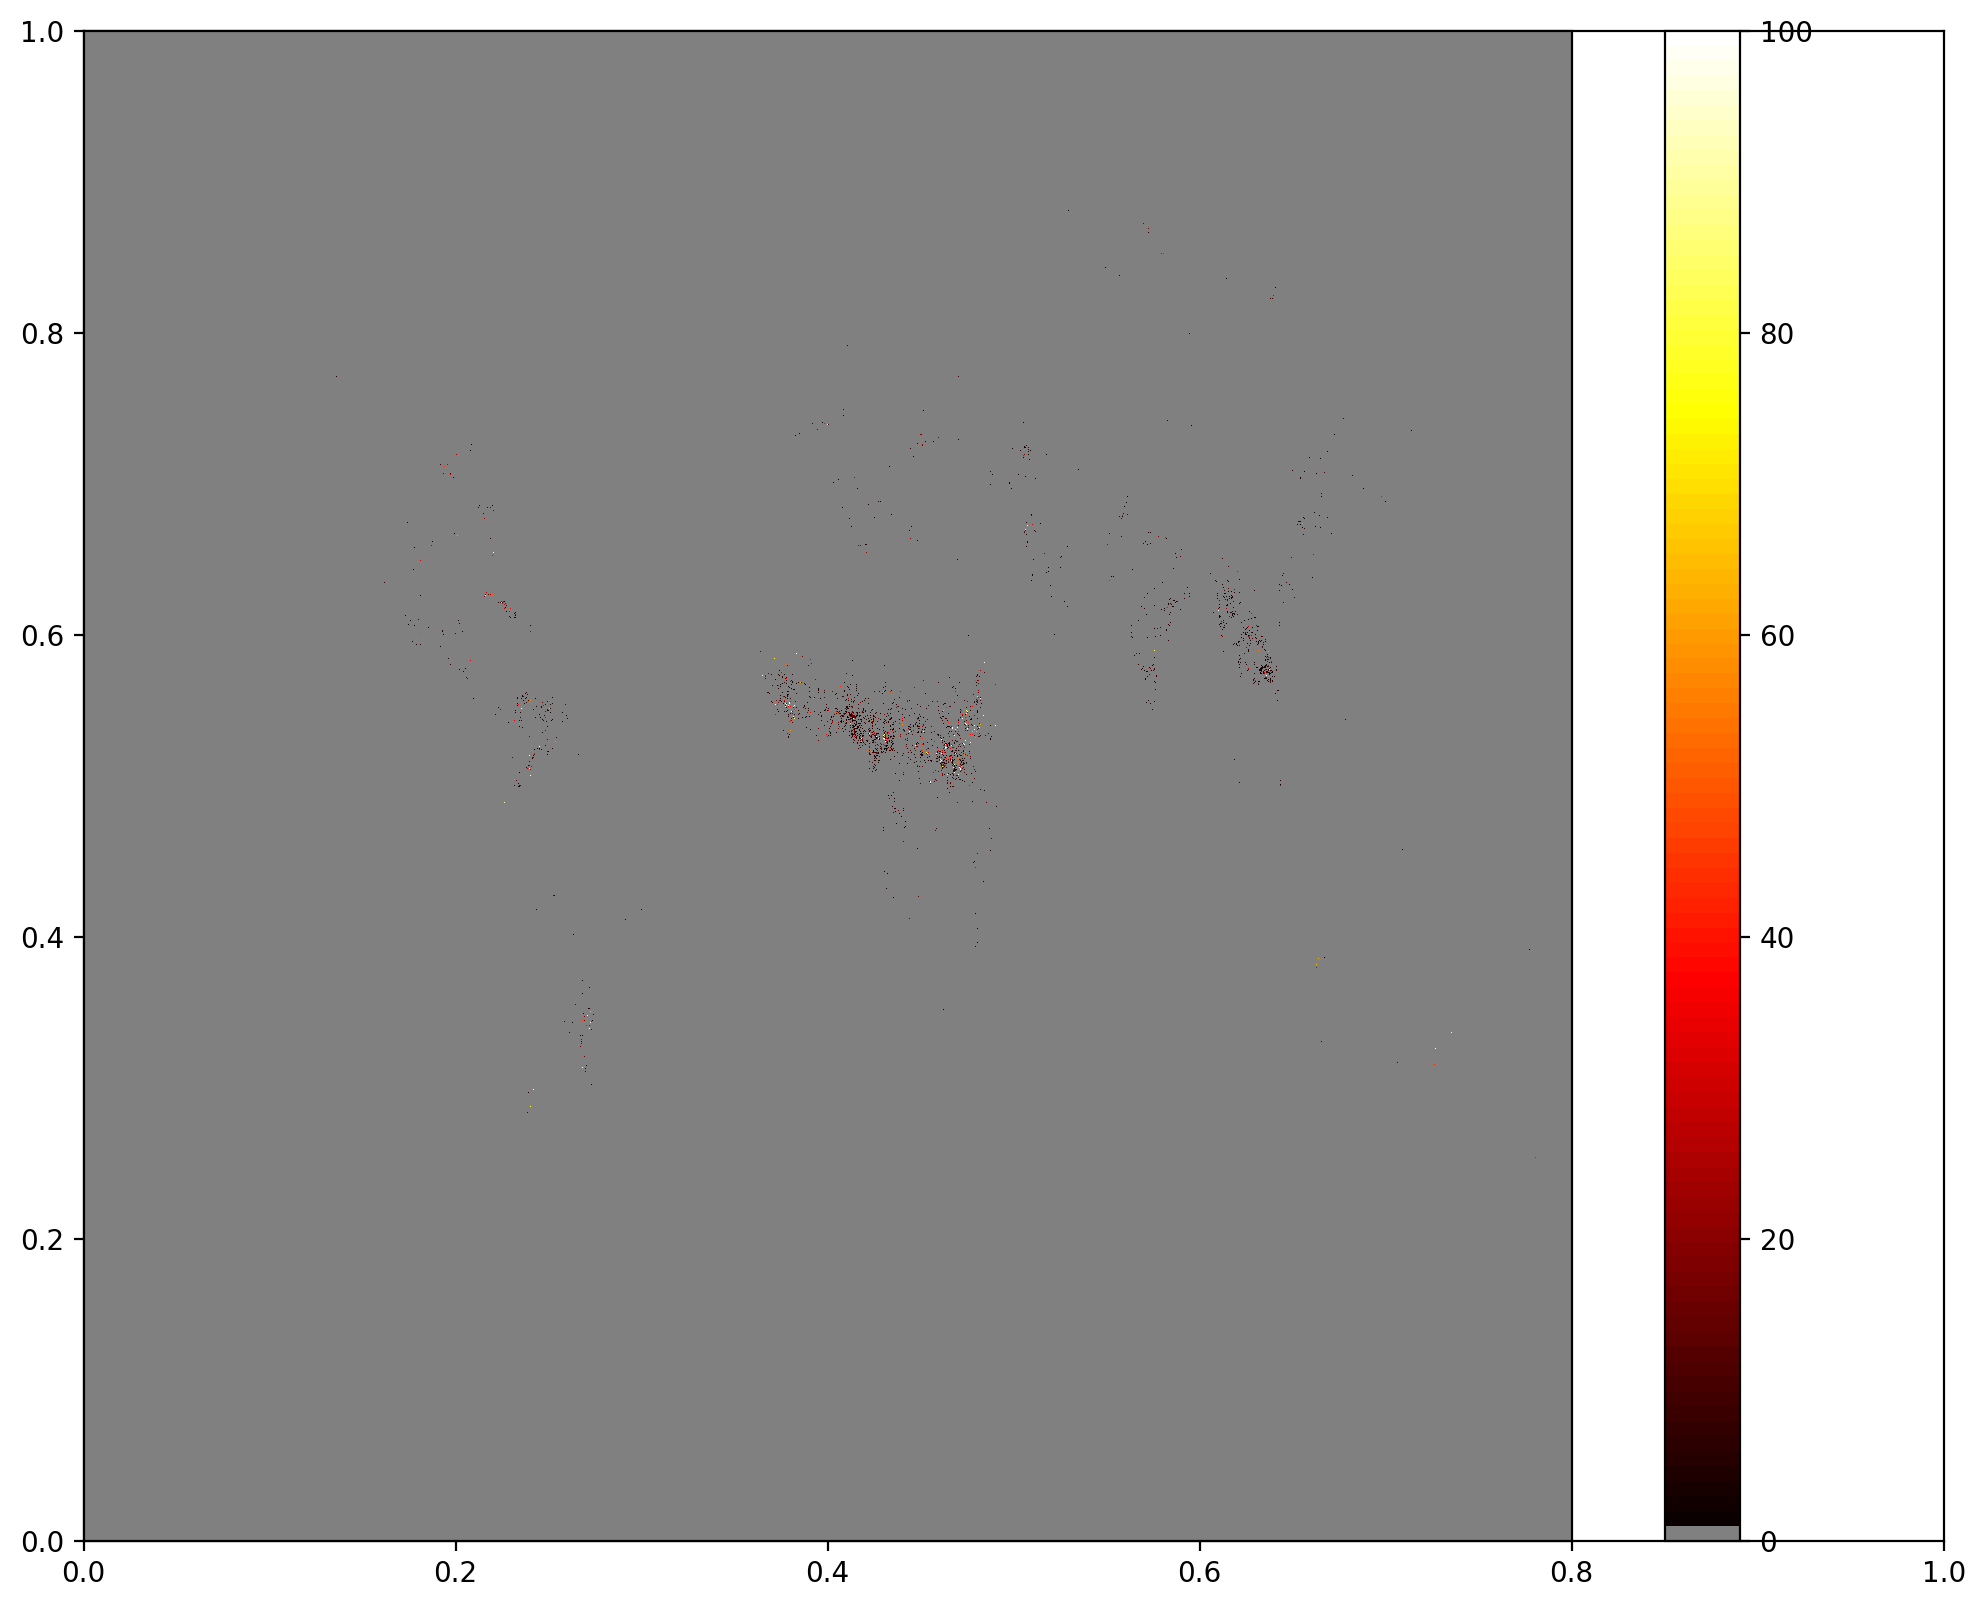

In [90]:
fig = figure(num=None, figsize=(12, 10), dpi=200, facecolor='w', edgecolor='k')

cmap = cm.get_cmap('hot', 100)   
#cmap = cm.get_cmap('jet', 100)   

color_list = ['#808080']
#color_list = ['#FFFFFF']


for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))
    
ax = fig.add_subplot(111)

ax = plt.axes(projection=ccrs.Mercator(min_latitude=-85.0, max_latitude=85.0, globe=None, latitude_true_scale=1))

cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)

plt.imshow(data.T, cmap=cmap, interpolation='nearest',aspect='auto', origin='lower',vmax=100)


#plt.imshow(data.T,vmax=100,vmin=1, origin='lower')

plt.colorbar()

plt.show()

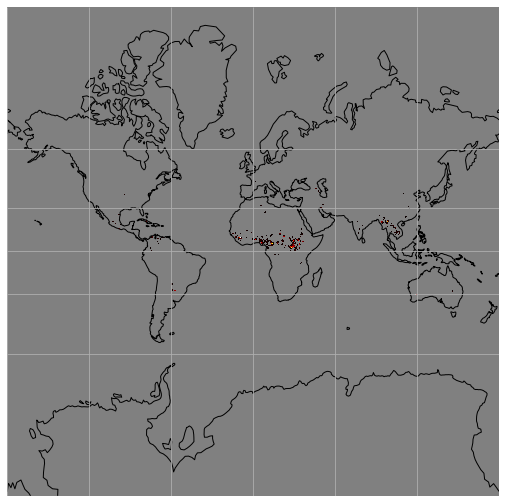

In [91]:
plt.figure(figsize=(16,9))


ax = plt.axes(projection=ccrs.Mercator(min_latitude=-85.0, max_latitude=85.0, globe=None, latitude_true_scale=1))

ax.set_axis_off()


ax.coastlines(resolution='110m')
ax.gridlines()

ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)

output_filename = "./outputs/Fire_Radiative_Power_Mercator_{:04d}_{:02d}_{:02d}.png".format(year,month,day)

plt.savefig(output_filename, bbox_inches='tight', dpi=200, facecolor='red', pad_inches = 0)

plt.show()

plt.close()

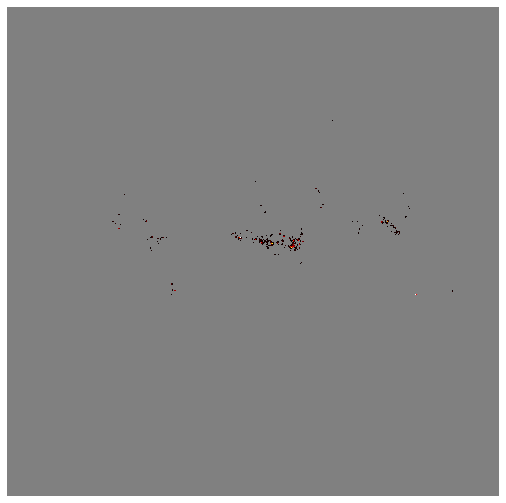

In [92]:
plt.figure(figsize=(16,9))


ax = plt.axes(projection=ccrs.Mercator(min_latitude=-85.0, max_latitude=85.0, globe=None, latitude_true_scale=1))

ax.set_axis_off()


#ax.coastlines(resolution='110m')
#ax.gridlines()

ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)

output_filename = "./outputs/Fire_Radiative_Power_Mercator_{:04d}_{:02d}_{:02d}.png".format(year,month,day)

plt.savefig(output_filename, bbox_inches='tight', dpi=1000, facecolor='red', pad_inches = 0, transparent=True)

plt.show()

plt.close()

In [93]:
data.sum()

491611.16

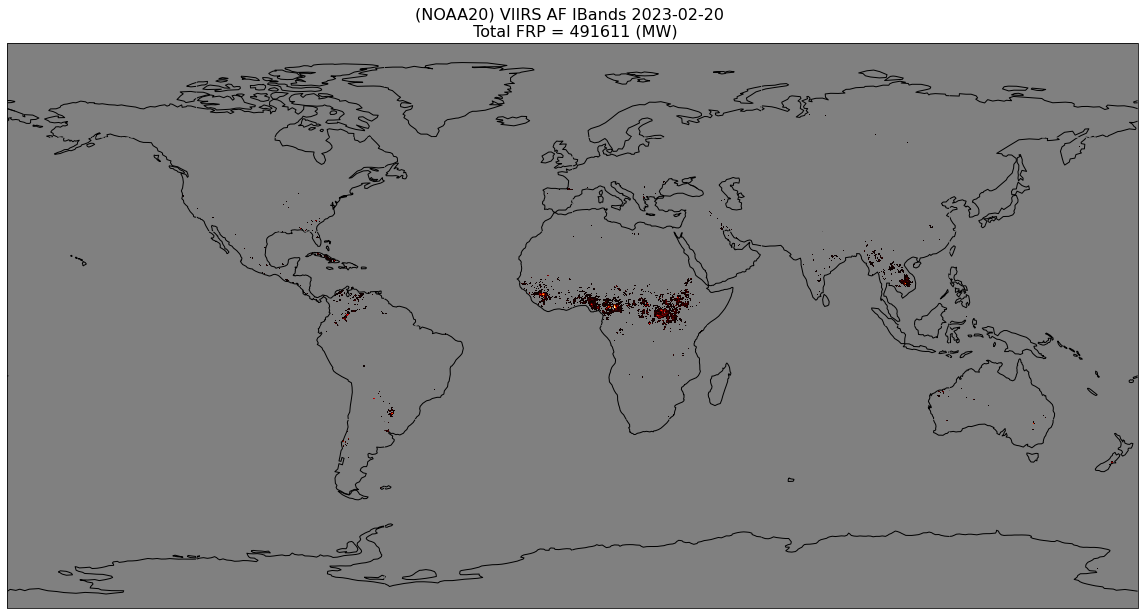

<function matplotlib.pyplot.close(fig=None)>

In [94]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)

tot_frp = round(data.sum())

plt.title('({}) VIIRS AF IBands {}-{:02d}-{:02d} \n Total FRP = {} (MW)'.format(platform,year,month,day,tot_frp),fontsize=16)

plt.tight_layout()

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200)

plt.show()

plt.close

In [96]:
data_snpp = np.loadtxt("snpp_VIIRS_FP_power_2022_09_01.txt")

data_snpp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
data_noaa20 = np.loadtxt("noaa20_VIIRS_FP_power_2022_09_01.txt")

data_noaa20

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
data_noaa20.shape

(7200, 3600)

In [149]:
df_combine = pd.DataFrame()

df_combine['data_snpp'] = data_snpp.ravel()
df_combine['data_noaa20'] = data_noaa20.ravel()

df_combine

,data_snpp,data_noaa20
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
25919995,0.0,0.0
25919996,0.0,0.0
25919997,0.0,0.0
25919998,0.0,0.0


In [150]:
df_combine['Comb'] = 0

In [151]:
df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ][['data_snpp','data_noaa20']]

,data_snpp,data_noaa20
4027424,17.950504,24.562412
4034625,71.939850,105.995422
4034626,34.467964,14.796156
4038218,105.703339,47.068604
4041819,178.534103,110.279549
...,...,...
25326926,328.522461,1346.229492
25330523,49.989231,2.486631
25334124,2.408252,21.599220
25413378,3.636982,1.472583


In [152]:
df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ][['data_snpp','data_noaa20']].mean(axis=1)

4027424      21.256458
4034625      88.967636
4034626      24.632060
4038218      76.385971
4041819     144.406826
               ...    
25326926    837.375977
25330523     26.237931
25334124     12.003736
25413378      2.554783
25539456     14.352086
Length: 12555, dtype: float64

In [153]:
df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ]['Comb']

4027424     0
4034625     0
4034626     0
4038218     0
4041819     0
           ..
25326926    0
25330523    0
25334124    0
25413378    0
25539456    0
Name: Comb, Length: 12555, dtype: int64

In [154]:
df_combine['Comb'][ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ] = df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ][['data_snpp','data_noaa20']].mean(axis=1)

In [155]:
df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] > 0) ]['Comb']

4027424      21.256458
4034625      88.967636
4034626      24.632060
4038218      76.385971
4041819     144.406826
               ...    
25326926    837.375977
25330523     26.237931
25334124     12.003736
25413378      2.554783
25539456     14.352086
Name: Comb, Length: 12555, dtype: float64

In [156]:
df_combine['Comb'][ (df_combine['data_snpp'] == 0) & (df_combine['data_noaa20'] > 0) ] = df_combine[ (df_combine['data_snpp'] == 0) & (df_combine['data_noaa20'] > 0) ][['data_snpp','data_noaa20']].sum(axis=1)

In [157]:
df_combine['Comb'][ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] == 0) ] = df_combine[ (df_combine['data_snpp'] > 0) & (df_combine['data_noaa20'] == 0) ][['data_snpp','data_noaa20']].sum(axis=1)

In [158]:
df_combine['Comb'].value_counts()

0.000000     25876871
6.908871            3
3.105161            2
31.503565           2
2.182935            2
               ...   
14.320961           1
0.637117            1
0.671980            1
4.476397            1
0.322809            1
Name: Comb, Length: 43020, dtype: int64

In [159]:
data = df_combine['Comb'].to_numpy()

data = data.reshape(data_noaa20.shape)

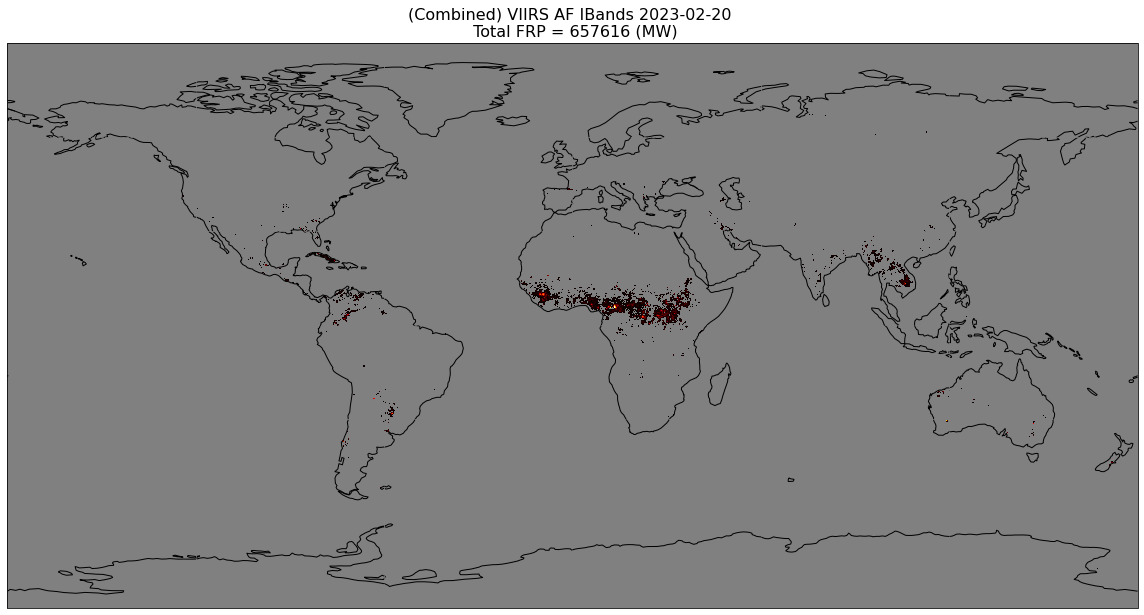

<function matplotlib.pyplot.close(fig=None)>

In [161]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)

tot_frp = round(data.sum())

plt.title('(Combined) VIIRS AF IBands {}-{:02d}-{:02d} \n Total FRP = {} (MW)'.format(year,month,day,tot_frp),fontsize=16)

plt.tight_layout()

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200)

plt.show()

plt.close